# Project: Investigate the Medical Appointment No-Show Dataset

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
<li><a href="#reference">Reference</a></li>
    
</ul>

<a id='intro'></a>
## Introduction

For this analyis, we will use the medical appointment dataset from Kaggle. This dataset contains over 110k observations of medical appointment with some variables of patients' demographics info. The goal of this analysis is to explore the factors that are correlated with patients' no-show of medical appointment. Some research questions we post for this analysis are:
>1. Are younger ages associated with missed appointments?
>2. Is enrolling in goverment welfare program associated with missed appointment?
>3. Is not receiving sms notificaiton associated with missed apppointment?
>4. Are the gap days between schedule date and appointment date associated with appointment no-show?
>5. Are there any correlations between the chronic disease/condition with appointment no-show?



In [1]:
# I will use Python pandas, matplotlib, numpy, seaborn and scipy.stats for this analysis.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind

%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

In this section of the report, we will load in the data, check for cleanliness, and then trim and clean the dataset for analysis. 

### General Properties: Explore the dataset first

In [2]:
# Load in the dataset appointment dataframe
appt_df=pd.read_csv("noshowappointments2016.csv")
# overview of the dataset info to see datatype of each var and if any missing data
appt_df.info();
# print the first 5 obs of the dataset
print(appt_df.head());

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB
      PatientId  AppointmentID Gender          ScheduledDay  \
0  2.987250e+13        5642

#### There are in total 110,527 obs and 14 variables in this dataset, and we can see there are no missing values for each variable. 

In [3]:
# take a look at the first 5 obs of the dataset
appt_df.head()
# transform column name to lower case and replace the - for easier analysis
appt_df.rename(columns=lambda x: x.strip().lower().replace("-","_"),inplace=True)
appt_df.head()

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [4]:
# check unique values of each var
appt_df.nunique()

patientid          62299
appointmentid     110527
gender                 2
scheduledday      103549
appointmentday        27
age                  104
neighbourhood         81
scholarship            2
hipertension           2
diabetes               2
alcoholism             2
handcap                5
sms_received           2
no_show                2
dtype: int64

In [5]:
# further check on the 2 date vars in this dataset
print(type(appt_df["appointmentday"][0]))
print(type(appt_df["scheduledday"][0]))

# transform datetime string to datetime format
appt_df["appointmentday"]=pd.to_datetime(appt_df["appointmentday"])
appt_df["scheduledday"]=pd.to_datetime(appt_df["scheduledday"])

appt_df.info()

<class 'str'>
<class 'str'>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   patientid       110527 non-null  float64            
 1   appointmentid   110527 non-null  int64              
 2   gender          110527 non-null  object             
 3   scheduledday    110527 non-null  datetime64[ns, UTC]
 4   appointmentday  110527 non-null  datetime64[ns, UTC]
 5   age             110527 non-null  int64              
 6   neighbourhood   110527 non-null  object             
 7   scholarship     110527 non-null  int64              
 8   hipertension    110527 non-null  int64              
 9   diabetes        110527 non-null  int64              
 10  alcoholism      110527 non-null  int64              
 11  handcap         110527 non-null  int64              
 12  sms_received    110527 non-null  int64      

In [6]:
# keep only the date portion of the date variables and check unique value
appt_df['app_just_date'] = appt_df['appointmentday'].dt.date
appt_df['sch_just_date'] = appt_df['scheduledday'].dt.date
# create a new variable of the gap between schedule date and appointment date
appt_df['gap'] = appt_df['app_just_date']  - appt_df['sch_just_date']
# tranform timedelta to interger format
appt_df['gap'] = appt_df['gap'].dt.days
print(appt_df.info())
appt_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   patientid       110527 non-null  float64            
 1   appointmentid   110527 non-null  int64              
 2   gender          110527 non-null  object             
 3   scheduledday    110527 non-null  datetime64[ns, UTC]
 4   appointmentday  110527 non-null  datetime64[ns, UTC]
 5   age             110527 non-null  int64              
 6   neighbourhood   110527 non-null  object             
 7   scholarship     110527 non-null  int64              
 8   hipertension    110527 non-null  int64              
 9   diabetes        110527 non-null  int64              
 10  alcoholism      110527 non-null  int64              
 11  handcap         110527 non-null  int64              
 12  sms_received    110527 non-null  int64              
 13  no_show       

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show,app_just_date,sch_just_date,gap
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No,2016-04-29,2016-04-29,0
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No,2016-04-29,2016-04-29,0
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No,2016-04-29,2016-04-29,0
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,2016-04-29,2016-04-29,0
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No,2016-04-29,2016-04-29,0


In [7]:
# check the basic stats of each var
appt_df.describe()

,patientid,appointmentid,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,gap
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,10.183702
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,15.254996
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,15.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,179.000000


#### From the basic statistic of all variables above, there are a few variables need to be fixed or dropped in next Data Cleaning Step:
>1. There should not be negative or zero Age values(max age 115 is possible though). 
>2. Gap day should also be 0 or positive since schedule date should be earlier or at the same day as the appointment date.
>3. In the data dictionary from Kaggle, Handcap variables should be have value of True of False (1 or 0), but in the dataset the values actually range from 0 to 4, which makes this variable less reliable.
>4. Add a more informative variable based on no_show.
>5. Drop unnecessary variables.
>6. Check duplicate observation.


### Data Cleaning: Fix invalid variables and Drop unneeded variables

#### 1.Clean Age values

In [8]:
# Output obs with invalid and valid age value to 2 datasets
age_invalid=appt_df[appt_df["age"]<=0]
age_valid=appt_df[appt_df["age"]>0]
print(age_invalid.shape)
print(age_valid.shape)


(3540, 17)
(106987, 17)


#### There are 3,540 obs with 0 or negative age value

age
-1       1
 0    3539
Name: patientid, dtype: int64


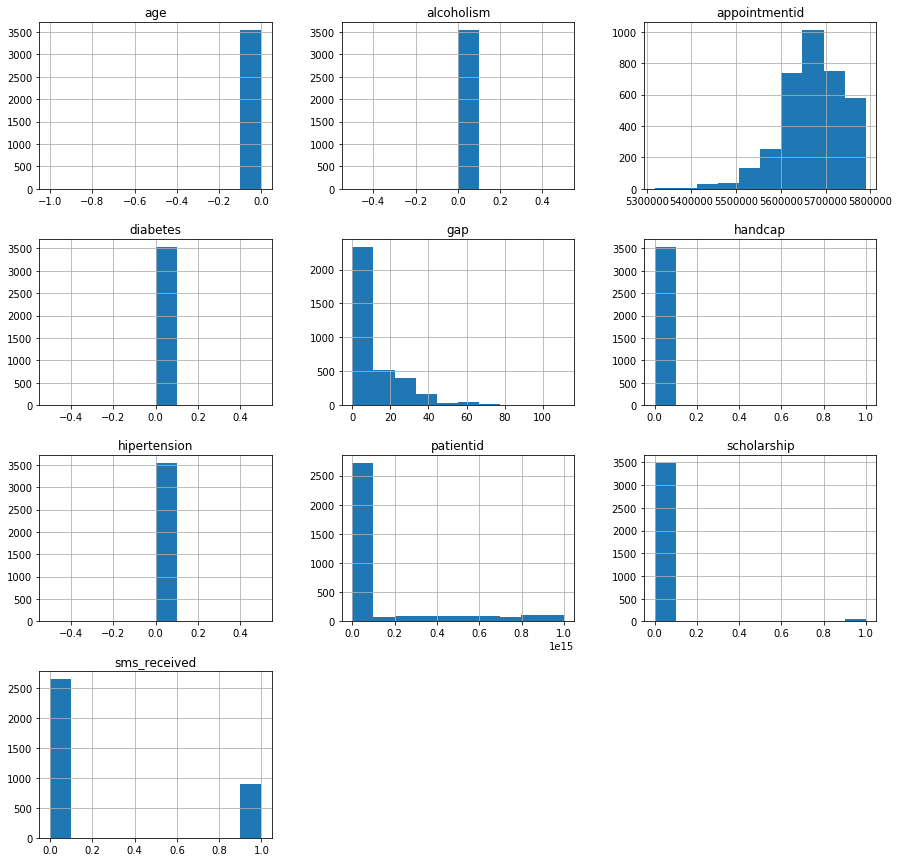

In [9]:
# count obs by invalid age value
print(age_invalid.groupby("age")["patientid"].count())
# check histogram from the patients group with invalid age value
age_invalid.hist(figsize=(15,15));

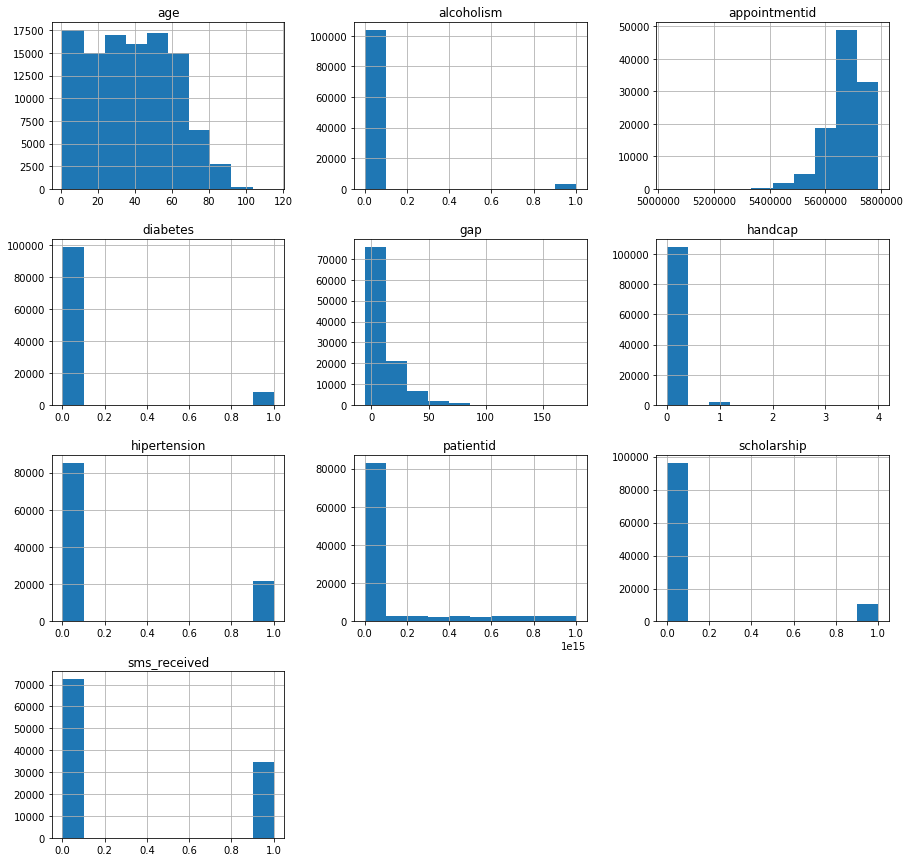

In [10]:
# check histogram of the patient group with valid age values
age_valid.hist(figsize=(15,15));

#### The overall distribution of other variables(except patientid and appointmentid) in observations with invalid age values are mostly similar to the distributions of other variables in valid age observations. So we will replace those invalid age values with mean age.

In [11]:
# replace the invalid age value with mean age
age_mean=age_valid["age"].mean()

# replace invalid age value to mean age from valid observations
appt_df.loc[appt_df.age <= 0, 'age'] = age_mean

In [12]:
# check to see if invalid age values are successfully replaced with mean
appt_df.describe()

,patientid,appointmentid,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,gap
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,38.316085,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,10.183702
std,2.560949e+14,7.129575e+04,22.103505,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,15.254996
min,3.921784e+04,5.030230e+06,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000
25%,4.172614e+12,5.640286e+06,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,38.316085,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,15.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,179.000000


#### 2. Fix Gap Days

In [13]:
# check how many invalid gap day values
appt_df.groupby("gap").patientid.count()

gap
-6          1
-1          4
 0      38563
 1       5213
 2       6725
        ...  
 155       10
 162       11
 169        8
 176       16
 179       10
Name: patientid, Length: 131, dtype: int64

#### There are only 5 invalid gap day values so we will just drop them.

In [14]:
# drop the 5 obs with invalid gap days
appt_df.drop(appt_df[appt_df['gap'] < 0].index, inplace=True)
# check whether successfully dropped the obs with invalid gap days
print(appt_df.groupby("gap").patientid.count())
appt_df.describe()

gap
0      38563
1       5213
2       6725
3       2737
4       5290
       ...  
155       10
162       11
169        8
176       16
179       10
Name: patientid, Length: 129, dtype: int64


,patientid,appointmentid,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,gap
count,1.105220e+05,1.105220e+05,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000
mean,1.474935e+14,5.675305e+06,38.316308,0.098270,0.197255,0.071868,0.030401,0.022231,0.321040,10.184253
std,2.560866e+14,7.129722e+04,22.103301,0.297681,0.397928,0.258270,0.171689,0.161493,0.466878,15.255115
min,3.921784e+04,5.030230e+06,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172536e+12,5.640284e+06,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173700e+13,5.680574e+06,38.316085,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,9.439277e+13,5.725525e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,15.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,179.000000


#### 3. Check Handcap Variable

In [15]:
# Check handcap variable 
appt_df.groupby("handcap")["patientid"].count()

handcap
0    108283
1      2040
2       183
3        13
4         3
Name: patientid, dtype: int64

#### Since the actual data value of Handcap didn't match the description in the data dictionary which described the Handcap variable as True/False, we will drop this variable in this analysis.

#### 4. Add a more informative var based on no_show variable

In [16]:
noshow_patient = appt_df.no_show == "Yes"
showed_patient = appt_df.no_show == "No"
appt_df['show_up'] = [1 if x == "No" else 0 for x in appt_df['no_show']] 
appt_df.head()

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show,app_just_date,sch_just_date,gap,show_up
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62.0,JARDIM DA PENHA,0,1,0,0,0,0,No,2016-04-29,2016-04-29,0,1
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56.0,JARDIM DA PENHA,0,0,0,0,0,0,No,2016-04-29,2016-04-29,0,1
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62.0,MATA DA PRAIA,0,0,0,0,0,0,No,2016-04-29,2016-04-29,0,1
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8.0,PONTAL DE CAMBURI,0,0,0,0,0,0,No,2016-04-29,2016-04-29,0,1
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56.0,JARDIM DA PENHA,0,1,1,0,0,0,No,2016-04-29,2016-04-29,0,1


#### 5. Drop unnecessary variables

In [17]:
# Drop variables that not needed in this analysis
appt_df.drop(columns=['scheduledday', 'appointmentday'],inplace=True)

#### 6. Final check on if any duplicate obs

In [18]:
print(sum(appt_df.duplicated()))
appt_df.info()

0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 110522 entries, 0 to 110526
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   patientid      110522 non-null  float64
 1   appointmentid  110522 non-null  int64  
 2   gender         110522 non-null  object 
 3   age            110522 non-null  float64
 4   neighbourhood  110522 non-null  object 
 5   scholarship    110522 non-null  int64  
 6   hipertension   110522 non-null  int64  
 7   diabetes       110522 non-null  int64  
 8   alcoholism     110522 non-null  int64  
 9   handcap        110522 non-null  int64  
 10  sms_received   110522 non-null  int64  
 11  no_show        110522 non-null  object 
 12  app_just_date  110522 non-null  object 
 13  sch_just_date  110522 non-null  object 
 14  gap            110522 non-null  int64  
 15  show_up        110522 non-null  int64  
dtypes: float64(2), int64(9), object(5)
memory usage: 14.3+ MB


#### Data Cleaning Summary:####
We cleaned up the data with invalid age and gap day values and kept only relevant vars which will be uses to explore the correlation with appointment no-show.

<a id='eda'></a>
## Exploratory Data Analysis

### Research Question 1 Are younger ages associated with missed appointments?

0.20189645500443354
show_up
0    35.415120
1    39.050222
Name: age, dtype: float64


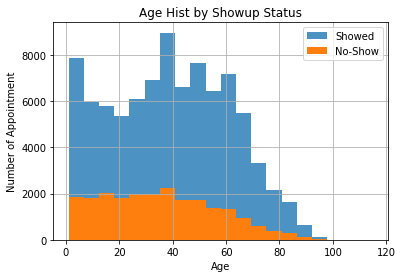

In [19]:
# Overall showup rate
print(1-appt_df["show_up"].mean())
# Calculate the mean age by showup status
print(appt_df.groupby("show_up").age.mean())

noshow_patient = appt_df.show_up == 0
showed_patient = appt_df.show_up == 1
# Plot histogram of age by Showup Status
appt_df.age[showed_patient].hist(alpha=0.8,bins=20,label="Showed")
appt_df.age[noshow_patient].hist(bins=20,label="No-Show")

plt.title("Age Hist by Showup Status")
plt.xlabel("Age")
plt.ylabel("Number of Appointment")
plt.legend();


#### The mean age for patients who missed the appointment are younger than those who showed up. 
We will perform a t-test to see if this difference is statistically significant.

In [20]:
from scipy.stats import ttest_ind

pval =ttest_ind(appt_df[showed_patient]["age"], appt_df[noshow_patient]["age"])
print(pval)

Ttest_indResult(statistic=21.995017604617164, pvalue=5.460816905484444e-107)


#### From the t-test, it is statistically significant that the mean age of 2 groups are different. 

### Research Question 2  Is welfare program enrollment associated with missed appointments?

scholarship
0    0.801969
1    0.762637
Name: show_up, dtype: float64


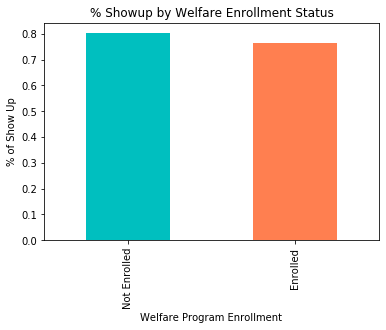

In [21]:
# calculate the mean of scholarship which is basically the % of showup by welfare program enrollment status
print(appt_df.groupby("scholarship").show_up.mean())
appt_df.groupby("scholarship").show_up.mean().plot(kind="bar",color=["c","coral"])
plt.title("% Showup by Welfare Enrollment Status")
plt.xlabel("Welfare Program Enrollment")
plt.ylabel("% of Show Up")
# edit the x ticks to make it more straightfoward
plt.xticks([0,1],labels=["Not Enrolled","Enrolled"]);

#### From people who did NOT enroll in the welfare program, the appointment showup rate is 80.2%; while this rate for people who enrolled in the welfare program is only 76.3%.

### Research Question 3 Is receiving sms notificaiton associated with missed apppointment?

sms_received
0    0.833022
1    0.724255
Name: show_up, dtype: float64


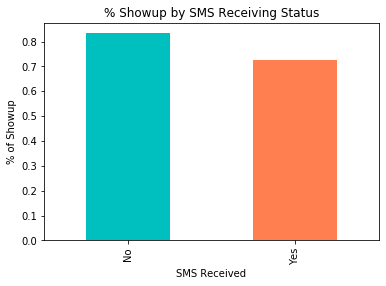

In [22]:
# calculate the mean of scholarship which is basically the % of ppl by showup status
print(appt_df.groupby("sms_received").show_up.mean())
appt_df.groupby("sms_received").show_up.mean().plot(kind="bar",color=["c","coral"]);
plt.title("% Showup by SMS Receiving Status")
plt.xlabel("SMS Received")
plt.ylabel("% of Showup")
# edit the x ticks to make it more straightfoward
plt.xticks([0,1],labels=["No","Yes"]);

This is a bit surprising that people who received SMS notifications actually showed a lower showup rate ~ 72.4% while the people who didn't receive SMS notifications have a showup rate ~83.3%.

### Research Question 4 Are the gap days between schedule date and appointment date associated with missed appointment?

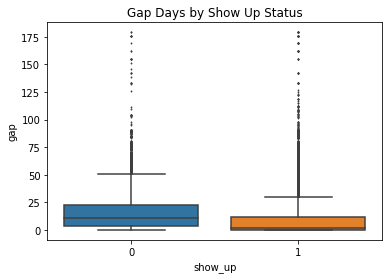

In [23]:
# plot a botplot by show up status
sns.boxplot(x="show_up", y="gap", data=appt_df, fliersize=1).set_title('Gap Days by Show Up Status');

,count,mean,std,min,25%,50%,75%,max
show_up,,,,,,,,
0,22314.0,15.835484,16.605600,0.0,4.0,11.0,23.0,179.0
1,88208.0,8.754659,14.550398,0.0,0.0,2.0,12.0,179.0


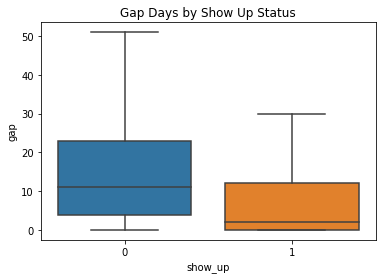

In [24]:
# outliers make it hard to intepret now drop the outliers
sns.boxplot(x="show_up", y="gap", data=appt_df,fliersize=1, showfliers=False).set_title('Gap Days by Show Up Status');
# calculate basic stats for gap by show up status
appt_df.groupby("show_up").gap.describe()

We can see that the missed appointments generally have bigger gap days which means the schedule date is a bit further from the actual appointment date compared to the showed up appointments.

### Research Question 5 Are there any correlation between the chronic disease or condition with appointment no-show?

#### 1) Hypertention

hipertension
0    0.791008
1    0.826980
Name: show_up, dtype: float64
Ttest_indResult(statistic=11.862544955960763, pvalue=1.938596233473919e-32)


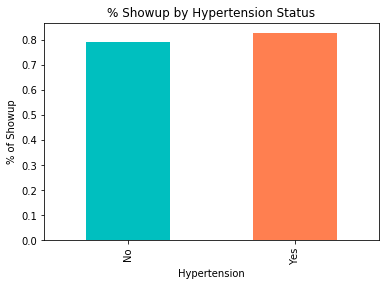

In [25]:
#plot bar chars of show rate by hypertension status
print(appt_df.groupby("hipertension").show_up.mean())
appt_df.groupby("hipertension").show_up.mean().plot(kind="bar", color=["c","coral"]);
plt.title("% Showup by Hypertension Status")
plt.xlabel("Hypertension")
plt.ylabel("% of Showup")
# edit the x ticks to make it more straightfoward
plt.xticks([0,1],labels=["No","Yes"]);
# t-test of the mean showup rate between 2 groups
hip_yes= appt_df.hipertension == 1
hip_no = appt_df.hipertension == 0
pval =ttest_ind(appt_df[hip_yes]["show_up"], appt_df[hip_no]["show_up"])
print(pval)

From the stats and the bar chart we can see that people with hypertension showed a higher showup rate ~82.7% while pepople without hypertension showed a showup rate ~ 79.1%. The difference is statistically significant at 5% level as the p-value < 0.05.

#### 2) Diabetes

diabetes
0    0.796411
1    0.819967
Name: show_up, dtype: float64
Ttest_indResult(statistic=5.039222121661703, pvalue=4.6816293068002867e-07)


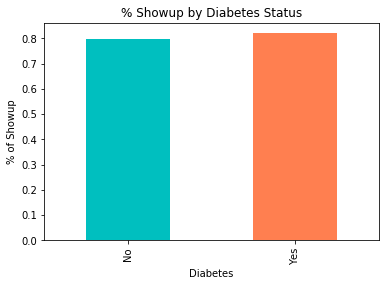

In [26]:
# plot bar chars of show rate by diabetes status
print(appt_df.groupby("diabetes").show_up.mean())
appt_df.groupby("diabetes").show_up.mean().plot(kind="bar",color=["c","coral"]);
plt.title("% Showup by Diabetes Status")
plt.xlabel("Diabetes")
plt.ylabel("% of Showup")
# edit the x ticks to make it more straightfoward
plt.xticks([0,1],labels=["No","Yes"]);
# t-test of the mean showup rate between 2 groups
diab_yes= appt_df.diabetes == 1
diab_no = appt_df.diabetes == 0
pval =ttest_ind(appt_df[diab_yes]["show_up"], appt_df[diab_no]["show_up"])
print(pval)

From the stats and the bar chart we can see that people with diabetes showed a slightly higher showup rate ~82.0% while pepople without diabetes showed a showup rate ~ 79.6%. The difference is small but statistically significant at 5% level as the p-value < 0.05.

#### 3) Alcoholism

alcoholism
0    0.798091
1    0.798512
Name: show_up, dtype: float64
Ttest_indResult(statistic=0.059885083390964954, pvalue=0.9522472685776348)


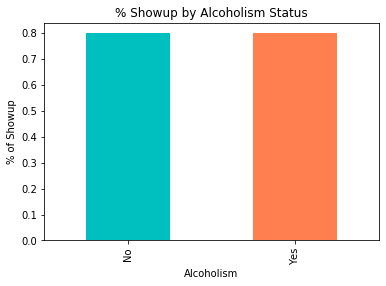

In [27]:
# plot bar chars of show rate by alcoholism status
print(appt_df.groupby("alcoholism").show_up.mean())
appt_df.groupby("alcoholism").show_up.mean().plot(kind="bar",color=["c","coral"]);
plt.title("% Showup by Alcoholism Status")
plt.xlabel("Alcoholism")
plt.ylabel("% of Showup")
# edit the x ticks to make it more straightfoward
plt.xticks([0,1],labels=["No","Yes"]);
# t-test of the mean showup rate between 2 groups
alc_yes= appt_df.alcoholism == 1
alc_no = appt_df.alcoholism == 0
pval =ttest_ind(appt_df[alc_yes]["show_up"], appt_df[alc_no]["show_up"])
print(pval)

From the stats and the bar chart we can see that people with alcoholism or not showed a very similar showup rate ~79.8%. The difference is not statistically significant as the p-value = 0.95.

<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed. Make sure that you are clear with regards to the limitations of your exploration. If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work, you should save a copy of the report in HTML or PDF form via the **File** > **Download as** submenu. Before exporting your report, check over it to make sure that the flow of the report is complete. You should probably remove all of the "Tip" quotes like this one so that the presentation is as tidy as possible. Congratulations!

In total there were 110,527 observations in the original dataset which is unique at medical appointment level. After data cleaning, there were 110,522 obs. 20.2% of these appointments are no-show appointments. 

From this analysis we found that younger age, enrolling in welfare program, not receiving sms, bigger gap days between schedule date and appointment date, as well as having hypertention, diabetes are associated with higher appointment no-show rate. While from this analysis we cannot make any causal implication, these correlations are statistically significant which may provide some information on better understanding people's medical appointment no-show behavious.

<a id='reference'></a>

## Reference
#### This section includes all resources I used for this analysis as reference.

#### keep only the date portion as the datetime doesnt matter in this analysis
https://stackoverflow.com/questions/56816833/pandas-pd-to-datetime-only-keep-time-do-not-date
#### transform column to lowercase
#####  https://intellipaat.com/community/28350/how-can-i-make-pandas-dataframe-column-headers-all-lowercase
#### Drop rows by condition
#####  https://thispointer.com/python-pandas-how-to-drop-rows-in-dataframe-by-conditions-on-column-values/
#### Plot colors and argument
##### https://matplotlib.org/api/_as_gen/matplotlib.pyplot.boxplot.html